In [345]:
from pickle import FALSE, TRUE
from networkx import DiGraph
import networkx as nx
import pandas as pd
from pathlib import Path
from math import sqrt
import numpy as np

import opendssdirect as dss

def none_to_empty(input) -> list:
    if input==None:
        out = []
    else:
        out = [input]
    return out

def term_str_to_set(term_str: str) -> set:
    term_set = set(map(int, term_str.split('.')))
    return term_set

elmt_dict = {
            'Transformer': 'xfmr', 
            'Line': 'line'
            }


class Line():
    def __init__(self, length: float, units: str, line_geo: str) -> None:
        self.length = length
        self.units = units
        self.line_geo = line_geo

    def length_in_miles(self) -> float:
        in_miles = {
            'mi': 1.,
            'kft': 1000./5280.,
            'ft': 1./5280.,
            'km': 3280.84/5280
            }
        len = self.length * in_miles[self.units]
        return len

class Load():
    def __init__(self, bus: str, kw: float, kvar: float, phases: int):
        self.kW = kw
        self.kvar = kvar
        self.phases = phases
        self.kV = 0.0
        self.terminals = ''
        self.is_delta = False

    def set_kV(self, bus_base_Vln: float):
        if self.phases==3:
            self.kV = sqrt(3)*bus_base_Vln
        else:
            self.kV = bus_base_Vln

class Xfmr():
    def __init__(self, xfmr: pd.Series) -> None:
        self.phases = int(xfmr.phases)
        self.windings = int(xfmr.windings)
        self.xpu = xfmr.X
        self.nll = xfmr.nll
        self.bus = []
        self.wnd_terms = []
        self.wnd_terms_set = []
        self.kV = []
        self.kVA = []
        self.conn = []
        self.rpu = []
        for w in range(1,(xfmr.windings+1)):
            self.bus.append(xfmr['bus'+str(w)])
            self.wnd_terms.append(str(xfmr['wnd'+str(w)+'_terms']))
            self.kV.append(xfmr['kV'+str(w)])
            self.kVA.append(xfmr['kVA'+str(w)])
            self.conn.append(xfmr['conn'+str(w)])
            self.rpu.append(float(xfmr['R']/xfmr['windings']))

    def active_terminals(self, highside: bool = False) -> set:
        if highside:
            s = 0
        else:
            s=-1
        buses = np.array(self.bus)
        windings = np.array(self.wnd_terms)
        terminals = [term_str_to_set(t) for t in windings[buses==self.bus[s]]]
        terminal_set = set().union(*terminals)
        return terminal_set

class Meter():

    def __init__(self, circ_element: str, bus1, bus2, registers: pd.DataFrame = pd.DataFrame()):
        self.name = 'meter_'+bus1+'-'+bus2
        self.c_elmt = circ_element
        self.b1 = bus1
        self.b2 = bus2
        self.registers = registers

    def to_DSS(self):
        dss_str = 'new energymeter.'+self.name
        dss_str += ' '+self.c_elmt+'.'
        dss_str += elmt_dict[self.c_elmt]+'_'+self.b1+'-'+self.b2+'_'+str(0)


class DistNetwork(DiGraph):

    def add_circuit(self, circuit_csv):
        circuit_df = pd.read_csv(circuit_csv)
        circuit_dict = circuit_df.squeeze().to_dict()
        self.circuit = circuit_dict    
    
    def add_nodes(self, node_csv):
        nodes_df = pd.read_csv(node_csv)
        for bus in nodes_df.index:
            bus_name = nodes_df['Bus'][bus]
            Loc_x = nodes_df['Graph_Loc_x'][bus]
            Loc_y = nodes_df['Graph_Loc_y'][bus]
            graph_coords = (Loc_x, Loc_y)
            self.add_node(bus_name, coords = graph_coords, hot_terminals = set())
        self.nodes[self.circuit['slack_bus']]['hot_terminals'].update({1,2,3})
    
    def add_line_geoms(self, lineGeoms_csv):
        line_geoms_df = pd.read_csv(lineGeoms_csv, 
                                    index_col='LineGeo'
                                    )
        self.line_geoms = line_geoms_df
        phase_dict = {'a':'1',
                      'b':'2',
                      'c':'3',
                      'ab': '1.2',
                      'ac': '1.3',
                      'bc': '2.3',
                      'abc': '1.2.3'}
        self.line_geoms['cond_pos'] = self.line_geoms['cond_pos'].map(phase_dict)
        self.line_geoms['terminals'] = self.line_geoms['cond_pos'].map(term_str_to_set)


    def get_network_wires(self) -> set:
        OH_line_geos = self.line_geoms['Type']=='OH'
        n_cond_select = self.line_geoms['Nphases'] != self.line_geoms['Nconds']
        ph_conductors = set(self.line_geoms['phase_cond'][OH_line_geos])
        n_conductors = set(self.line_geoms['neutral_cond'][n_cond_select])
        return n_conductors.union(ph_conductors)

    def get_network_cnwires(self) -> set:
        CN_line_geos = self.line_geoms['Type']=='CN'
        cn_conductors = set(self.line_geoms['neutral_cond'][CN_line_geos])
        return cn_conductors
    
    def add_wiredata(self, wireData_csv):
        columns = ['Type',
                   'GMRac',
                   'GMRunits',
                   'rac',
                   'runits',
                   'normamps'
                   ]
        wire_data_df = pd.read_csv(wireData_csv, index_col='Type', usecols=columns)
        wires = wire_data_df.index
        wset = wires.isin(self.get_network_wires())
        self.wire_data = wire_data_df.loc[wset]

    def add_CNdata(self, CNData_csv):
        columns = ['Type',
                   'GMRac',
                   'GmrStrand',
                   'GMRunits',
                   'Rac',
                   'Rstrand',
                   'Runits',
                   'DiaCable',
                   'DiaIns',
                   'DiaStrand',
                   'diam',
                   'Radunits',
                   'normamps',
                   'k'
                   ]
        CN_data_df = pd.read_csv(CNData_csv, index_col='Type', usecols=columns)
        cn_wires = CN_data_df.index
        cnset = cn_wires.isin(self.get_network_cnwires())
        self.CN_data = CN_data_df.loc[cnset]
    
    def add_edge_DN(self, u, v, 
                    line: Line = None, 
                    xfmr: Xfmr = None, 
                    length: float = 0.):
       l = none_to_empty(line)
       x = none_to_empty(xfmr)
       self.add_edge(u, v, lines = l, xfmrs = x, length = length)

    def add_lines(self, lines_csv):
        lines_df = pd.read_csv(lines_csv)
        for line in lines_df.index:
            Bus1 = lines_df['bus1'][line]
            Bus2 = lines_df['bus2'][line]
            length = lines_df['Length'][line]
            units = lines_df['Units'][line]
            line_geo = lines_df['LineGeometry'][line]
            newline = Line(length, units, line_geo)
            hot_terminals = set(self.line_geoms['terminals'][line_geo])
            self.nodes[Bus2]['hot_terminals'].update(hot_terminals.difference({0}))
            if self.has_edge(Bus1, Bus2):
                self[Bus1][Bus2]['lines'].append(newline)
                self[Bus1][Bus2]['length'] = newline.length_in_miles()
                if self[Bus1][Bus2]['xfmrs']:
                    print(f'Adding line across pre-existing xfmr betwen {Bus1} and {Bus2}')
                else:
                    pass
            else:
                self.add_edge_DN(
                          Bus1, 
                          Bus2,
                          line = newline,
                          length = newline.length_in_miles(),
                          )
    
    def add_loads(self, loads_csv):
        loads_df = pd.read_csv(loads_csv)
        for load in loads_df.index:
            bus = loads_df['Bus'][load]
            load_kW = loads_df['kW'][load]
            load_kVAr = loads_df['kVAr'][load]
            phases = loads_df['Phases'][load]
            newload = Load(bus=bus, kw=load_kW, kvar=load_kVAr, phases=phases)

            ht = self.nodes[bus]['hot_terminals']
            load_terms = str(loads_df['CondPos'][load])
            load_term_set = term_str_to_set(load_terms)
            for t in load_term_set:
                if t not in ht:
                    print(f'Load at {bus} connected to terminal {t} which is not energized')
                else:
                    pass
            newload.terminals = load_terms
            bus_base_Vln = self.nodes[bus]['Vln_base']
            newload.set_kV(bus_base_Vln)
            if newload.phases>1:
                upstrm_xfmr = self.get_upstream_xfmr(bus)
                if upstrm_xfmr.conn[-1]=='delta':
                    newload.is_delta = True
            self.nodes[bus]['load'] = newload

    def downstream_loads(self, node: str, as_kVA: bool = False):
        ds_nodes = [node]
        ds_nodes += list(nx.descendants(self, node))
        ds_kW = 0.0
        ds_kVAr = 0.0
        for n in ds_nodes:
            if 'load' in self.nodes[n]:
                ds_kW += self.nodes[n]['load'].kW
                ds_kVAr += self.nodes[n]['load'].kvar
            else:
                pass
        if as_kVA:
            kVA = sqrt(ds_kW**2 + ds_kVAr**2)
            return kVA
        else:
            load_tuple = (ds_kW, ds_kVAr)
            return load_tuple

    def add_xfmrs(self, xfmr_csv):
        xfmr_df = pd.read_csv(xfmr_csv)
        for x in xfmr_df.index:
            xfmr = xfmr_df.loc[x]
            new_xfmr = Xfmr(xfmr)
            Bus1 = new_xfmr.bus[0]
            Bus2 = new_xfmr.bus[-1]
            self.nodes[Bus2]['hot_terminals'].update(new_xfmr.active_terminals())
            if self.has_edge(Bus1, Bus2):
                self[Bus1][Bus2]['xfmr'].append(new_xfmr)
                self[Bus1][Bus2]['length'] = 0.
                if self[Bus1][Bus2]['lines']:
                    print (f'Adding xfmr across pre-existing line betwen {Bus1} and {Bus2}')
                else:
                    pass
            else:
                self.add_edge_DN(Bus1, Bus2, xfmr = new_xfmr)

    def calc_electrical_distance(self):
        source_node = self.circuit['slack_bus']
        for n in self.nodes:
            len = nx.dijkstra_path_length(self, source=source_node, target=n , weight='length')
            self.nodes[n]['dist_from_source'] = len

    def get_upstream_xfmr(self, node: str) -> Xfmr:
        b1 = node
        while b1 != self.circuit['slack_bus']:
            b2 = next(self.predecessors(b1))
            if self[b2][b1]['xfmrs']: #If xfmrs list is non-empty, then:
                xfmr = self[b2][b1]['xfmrs'][0]
                return xfmr
            else: # if xfmrs list is empty then:
                b1 = b2
    
    def calc_Vbases(self):
        for n in self.nodes:
            if n==self.circuit['slack_bus']:
                Vbase = self.circuit['basekv']
            else:
                upstrm_xfmr = self.get_upstream_xfmr(n)
                if upstrm_xfmr.phases==3:
                    Vbase = (1/sqrt(3)) * upstrm_xfmr.kV[-1]
                elif upstrm_xfmr.conn[-1]=='delta':
                    Vbase = (1/sqrt(3)) * upstrm_xfmr.kV[-1]
                else:
                    Vbase = upstrm_xfmr.kV[-1]
            self.nodes[n]['Vln_base'] = Vbase*1000

    def get_line_terminals(self, node: str):
        prev_node = next(self.predecessors(node))

    def check_floating_lines(self):
        for n in self.nodes:
            n_ht = self.nodes[n]['hot_terminals']
            for m in self.predecessors(n):
                m_ht = self.nodes[m]['hot_terminals']
                for t in n_ht:
                    if t not in m_ht:
                        print(f'There exists no terminal {t} connection between nodes {n} and {m}')
                    else:
                        pass

    def add_network_components(self, component_csvs: dict):
        
        circuit_csv = Path('..', 'network-data', component_csvs['circuit'])
        self.add_circuit(circuit_csv)
        
        bus_csv = Path('..', 'network-data', component_csvs['nodes'])
        self.add_nodes(bus_csv)
        
        lineGeo_csv = Path('..', 'network-data', component_csvs['line_geos'])
        self.add_line_geoms(lineGeo_csv)
        
        wireData_csv = Path('..', 'network-data', component_csvs['wire_data'])
        self.add_wiredata(wireData_csv)
        CNData_csv = Path('..', 'network-data', component_csvs['CN_data'])
        self.add_CNdata(CNData_csv)
        
        lines_csv = Path('..', 'network-data', component_csvs['lines'])
        self.add_lines(lines_csv)

        xfmrs_csv = Path('..', 'network-data', component_csvs['xfmrs'])
        self.add_xfmrs(xfmrs_csv)

        self.calc_Vbases()

        loads_csv = Path('..', 'network-data', component_csvs['loads'])
        self.add_loads(loads_csv)

        self.calc_electrical_distance()
        
        self.check_floating_lines()



    def clear_DSS(self):
        dss.run_command("clear")

    def solve_DSS(self):
        dss.run_command('set maxiterations=300')
        dss.run_command('set maxcontroliter=300')
        dss.run_command('solve')

    def new_circuit_DSS(self):
        cmd = dss.run_command
        circ = self.circuit

        dss_str = 'new circuit.slack bus1=' + circ['slack_bus']
        dss_str += ' basekv=' + str(circ['basekv'])
        dss_str += ' pu=' + str(circ['pu'])
        dss_str += ' phases=' + str(circ['phases'])
        dss_str += ' Z1=['+str(circ['R_1'])+', '+str(circ['X_1'])+']' #Z1=[R_1, X_1]
        dss_str += ' Z0=['+str(circ['R_0'])+', '+str(circ['X_0'])+']' #Z0=[R_0, X_0]
        cmd(dss_str)

    def new_wire_DSS(self, wire_name: str, wire_data: pd.Series):
        dss_str = 'new wiredata.' + wire_name
        for index, value in wire_data.items():
            dss_str += ' ' + index + '=' + str(value)
        dss.run_command(dss_str)

    def new_cnwire_DSS(self, cnwire_name: str, cnwire_data: pd.Series):
        dss_str = 'new cndata.' + cnwire_name
        for index, value in cnwire_data.items():
            dss_str += ' ' + index + '=' + str(value)
        dss.run_command(dss_str)

    def new_linegeo_DSS(self, lg_name: str, lg: pd.Series):
        dss_str = 'new lineGeometry.' + lg_name
        dss_str += ' Nconds=' + str(lg.Nconds)
        dss_str += ' Nphases=' + str(lg.Nphases)
        dss_str += ' Units=' + str(lg.Units)
        for cond in range(1, lg.Nconds+1):
            dss_str += ' Cond=' + str(cond)
            if lg.Type=='OH':
                dss_str += ' wire=' + str(lg.phase_cond)
            elif lg.Type=='CN':
                dss_str += ' cnCable=' + str(lg.neutral_cond)
            else:
                pass
            xcol = str(cond) + '_x'
            zcol = str(cond) + '_z'
            dss_str += ' X=' + str(lg[xcol])
            dss_str += ' H=' + str(lg[zcol])
            if lg.Nconds > lg.Nphases:
                dss_str += ' reduce=y'
            else:
                dss_str += ' reduce=n'
        dss.run_command(dss_str)

    def new_line_DSS(self, b1: str, b2: str, line: Line, id: int):
        dss_str = 'New Line.line_'+b1+'-'+b2+'_'+str(id)
        dss_str += ' Length=' + str(line.length)
        dss_str += ' Units=' + line.units
        lg = self.line_geoms.loc[line.line_geo]
        dss_str += ' Bus1=' + b1 + '.' + str(lg.cond_pos)
        dss_str += ' Bus2=' + b2 + '.' + str(lg.cond_pos)
        dss_str += ' phases=' + str(lg.Nphases)
        dss_str += ' Geometry=' + str(line.line_geo)
        dss.run_command(dss_str)

    def new_xfmr_DSS(self, b1: str, b2: str, xfmr: Xfmr, id: int):
        dss_str = 'new transformer.xfmr_'+b1+'-'+b2+'_'+str(id)
        dss_str += ' phases=' + str(xfmr.phases)
        dss_str += ' windings=' + str(xfmr.windings)
        dss_str += ' XHL=' + str(xfmr.xpu)
        dss_str += ' %noloadloss=' + str(xfmr.nll)
        for w in range(xfmr.windings):
            dss_str += ' wdg=' + str(w+1)
            dss_str += ' bus=' + xfmr.bus[w] + '.' + str(xfmr.wnd_terms[w])
            dss_str += ' conn=' + str(xfmr.conn[w])
            dss_str += ' kV=' + str(xfmr.kV[w])
            dss_str += ' kVA=' + str(xfmr.kVA[w])
            dss_str += ' %R=' + str(xfmr.rpu[w])
        dss.run_command(dss_str)


    def new_load_DSS(self, node: str, load: Load):
        dss_str = 'New Load.load_' + node
        dss_str += ' Bus1=' + node + '.' + load.terminals
        dss_str += ' Phases=' + str(load.phases)
        dss_str += ' kw=' + str(load.kW)
        dss_str += ' kvar=' + str(load.kvar)
        dss_str += ' kv=' + str(load.kV)
        if load.is_delta:
            dss_str += ' conn=delta'
        dss.run_command(dss_str)


    def compile_DSS(self):
        self.clear_DSS()

        self.new_circuit_DSS()

        #compile wriedata
        for wire in self.wire_data.index:
            wd = self.wire_data.loc[wire]
            self.new_wire_DSS(wire, wd)
        
        #compile CNdata
        for cnwire in self.CN_data.index:
            cnwd = self.CN_data.loc[cnwire]
            self.new_cnwire_DSS(cnwire, cnwd)

        #compile line geometries
        for line_geo in self.line_geoms.index:
            lg = self.line_geoms.loc[line_geo]
            self.new_linegeo_DSS(line_geo, lg)
        
        #compile lines
        for b1, b2, e in self.edges.data('lines'):
            if e: #in lines attr is a non-empty list then:
                for l in range(len(self[b1][b2]['lines'])):
                    line = self[b1][b2]['lines'][l]
                    self.new_line_DSS(b1, b2, line, l)
            else: #if lines attr is an empty list then:
                pass

        #compile xfmrs
        xfmr_Vbases = set()
        for b1, b2, e in self.edges.data('xfmrs'):
            if e: #if xfmrs attr is a non-empty list then:
                for x in range(len(self[b1][b2]['xfmrs'])):
                    xfmr = self[b1][b2]['xfmrs'][x]
                    xfmr_Vbases.union(set(xfmr.kV))
                    self.new_xfmr_DSS(b1, b2, xfmr=xfmr, id=x)
            else: #if xfmrs attr is an empty list then:
                pass
        vb_str = 'Set Voltagebases = '
        vb_str += '[' + ', '.join([str(v) for v in xfmr_Vbases]) + ']'
        dss.run_command(vb_str)
        dss.run_command('Calcvoltagebases')

        #compile loads
        for n, load in self.nodes(data='load'):
            if type(load)==Load:
                self.new_load_DSS(n, load)
            else:
                pass

    def record_DSS_bus_voltages(self):
        for bus in self.nodes:
            dss.Circuit.SetActiveBus(bus)
            voltage = np.array(dss.Bus.VMagAngle())
            voltage = voltage.reshape(int(voltage.size/2),2)
            terms = DN.nodes[bus]['hot_terminals']
            vbase = DN.nodes[bus]['Vln_base']
            bus_voltage = pd.DataFrame({
                                        'Vmag': voltage[:,0], 
                                        'Vang': voltage[:, 1], 
                                        'Vpu': (1/(vbase))*voltage[:,0]
                                        }, index=terms)
            self.nodes[bus]['voltage'] = bus_voltage

    





In [346]:
def main():
    Dnetwork = DistNetwork()

    components = {'nodes': 'nodes.csv',
              'line_geos': 'LineGeometry.csv',
              'wire_data': 'WireData.csv',
              'CN_data': 'CNData.csv',
              'lines': 'lines.csv',
              'loads': 'loads.csv',
              'xfmrs': 'xfmrs.csv',
              'circuit': 'circuit.csv'}
    
    Dnetwork.add_network_components(components)

    Dnetwork.compile_DSS()
    sub_meter = Meter(circ_element='Transformer', bus1='src_node', bus2='n0')
    sub_meter.to_DSS()

    Dnetwork.solve_DSS()
    Dnetwork.record_DSS_bus_voltages()
    return Dnetwork
    

DN = main()

In [342]:
testnp = np.zeros((1,2,2))
newnp = np.array([[[1,3],[2,4]]])
testnp = np.append(testnp, newnp, axis=0)
testnp = np.append(testnp, newnp+3, axis=0)

print(testnp[1:])

[[[1. 3.]
  [2. 4.]]

 [[4. 6.]
  [5. 7.]]]


In [318]:
xs = np.array([1,2,3,4])
full = np.zeros((3,4,2))
full[:,:,0] = xs
ys = xs[:3, np.newaxis] + xs[np.newaxis, :]
full[:,:,1] = ys
full[1,2,1] = 6


print(full)

[[[1. 2.]
  [2. 3.]
  [3. 4.]
  [4. 5.]]

 [[1. 3.]
  [2. 4.]
  [3. 6.]
  [4. 6.]]

 [[1. 4.]
  [2. 5.]
  [3. 6.]
  [4. 7.]]]


In [361]:
pltlines = np.empty((1,2,2))
for b1, b2, e in DN.edges(data = 'lines'):
    if e:
        for t in DN.nodes[b2]['hot_terminals']:
            if DN.nodes[b1]['voltage'].Vpu[t]<0.8:
                print(b1, t)
            pltline = np.empty((1,2,2))
            pltline[0, 0, 0] = DN.nodes[b1]['dist_from_source']
            pltline[0, 1, 0] = DN.nodes[b2]['dist_from_source']
            pltline[0, 0, 1] = DN.nodes[b1]['voltage'].Vpu[t]
            pltline[0, 1, 1] = DN.nodes[b2]['voltage'].Vpu[t]
            pltlines = np.append(pltlines, pltline, axis=0)


In [352]:
srcV = DN.nodes['src_node']['voltage']
print(srcV.Vmag)

1    71567.946321
2    71568.040702
3    71568.078052
Name: Vmag, dtype: float64


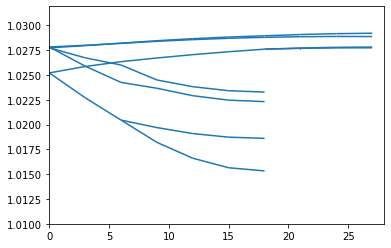

In [364]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

fig, ax = plt.subplots()
ax.set_xlim(pltlines[1:, :, 0].min(),pltlines[1:, :, 0].max()+1)
ax.set_ylim(1.01, pltlines[1:, :, 1].max())

line_segments = LineCollection(pltlines[1:, :, :])
ax.add_collection(line_segments)

plt.show()

In [298]:
bus = 'n5'
dss.Circuit.SetActiveBus(bus)
voltage = np.array(dss.Bus.VMagAngle())
voltage = voltage.reshape(int(voltage.size/2),2)
terms = DN.nodes[bus]['hot_terminals']
vbase = DN.nodes[bus]['Vln_base']
print(vbase)
bus_voltage = pd.DataFrame({
                            'Vmag': voltage[:,0], 
                            'Vang': voltage[:, 1], 
                            'Vpu': (1/(vbase))*voltage[:,0]
                            }, index=terms)
bus_voltage


240.17771198288435


,Vmag,Vang,Vpu
1,214.040341,-60.053420,0.891175
3,214.040344,119.946582,0.891175


In [277]:
dss.utils.transformers_to_dataframe()


,IsDelta,MaxTap,MinTap,Name,NumTaps,NumWindings,R,Rneut,Tap,Wdg,...,Xlt,Xneut,kV,kVA,Idx,CoreType,RdcOhms,WdgCurrents,WdgVoltages,LossesByType
xfmr_src_node-n0_0,False,1.1,0.9,xfmr_src_node-n0_0,32,2,0.179,-1.0,1.0,2,...,30.0,0.0,12.47,2000.0,1,0,0.039432,"[1.8829640903477411, -2.432231795841375, -1.88...","[6254.119094888194, -3844.808391366246, -6408....","[5613.516828946187, 56172.80291228008, 3567.99..."
xfmr_n14-n24_0,True,1.1,0.9,xfmr_n14-n24_0,32,2,0.5,-1.0,1.0,2,...,30.0,0.0,0.416,150.0,2,0,0.004903,"[3.64164610624789, -1.6744579573447709, -3.641...","[350.74052642766543, -225.366813072525, -363.6...","[620.6923495442497, 677.3071846329749, 356.412..."
xfmr_n15-n9_0,True,1.1,0.9,xfmr_n15-n9_0,32,2,0.5,-1.0,1.0,2,...,30.0,0.0,0.416,150.0,3,0,0.004903,"[4.137470663207026, -1.6348147161085649, -4.13...","[344.8175069236045, -225.29617660397776, -357....","[686.0514615832653, 816.1342849114726, 429.481..."
xfmr_n17-n5_0,False,1.1,0.9,xfmr_n17-n5_0,32,2,0.5,-1.0,1.0,2,...,30.0,0.0,0.416,75.0,4,0,0.009807,"[0.566610135490194, -4.535087724182546, -0.566...","[181.2160623553284, -357.3523395286652]","[558.317836400849, 866.2336181978735, 433.0815..."
xfmr_n20-n39_0,False,1.1,0.9,xfmr_n20-n39_0,32,2,0.6,-1.0,1.0,2,...,30.0,0.0,0.24,50.0,5,0,0.005875,"[-4.634046954889868, 0.006443934274585672, 4.6...","[-187.07411647734818, -77.8553746126498]","[338.4577364344186, 445.3297864009164, 267.176..."
xfmr_n23-n44_0,True,1.1,0.9,xfmr_n23-n44_0,32,2,0.35,-1.0,1.0,2,...,30.0,0.0,0.416,300.0,6,0,0.001716,"[9.299862641496393, -6.586467219464822, -9.299...","[316.82901208323767, -228.52686761843015, -334...","[1247.7175516260395, 4348.205423910807, 948.16..."
xfmr_n31-n28_0,True,1.1,0.9,xfmr_n31-n28_0,32,2,0.5,-1.0,1.0,2,...,30.0,0.0,0.416,150.0,7,0,0.004903,"[6.380352536035019, -6.079483968687327, -6.380...","[345.85620371181926, -220.22510997334552, -356...","[1792.2885084740774, 2919.3902265694087, 1536...."


In [37]:
xfmr_nodes = ['n0','n24','n9','n5','n28','n39','n44']

for n in xfmr_nodes:
    print((n,DN.downstream_loads(n, as_kVA=True)))

('n0', 1268.128148098606)
('n24', 61.84658438426491)
('n9', 53.85164807134504)
('n5', 55.97320787662612)
('n28', 129.71121771072848)
('n39', 36.76955262170047)
('n44', 156.52475842498527)


In [173]:
DN.nodes['n11']['Vln_base']

0.24

In [220]:
for n, load in DN.nodes(data='load'):
    print(n)

src_node
n0
n1
n2
n3
n4
n5
n6
n7
n8
n9
n10
n11
n12
n13
n14
n15
n16
n17
n18
n19
n20
n21
n22
n23
n24
n25
n26
n27
n28
n29
n30
n31
n32
n33
n34
n35
n36
n37
n38
n39
n40
n41
n42
n43
n44


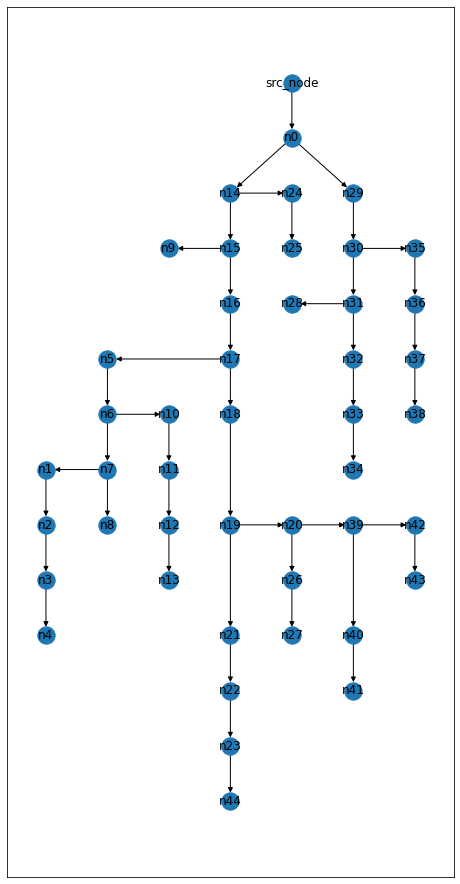

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,16))
nx.draw_networkx(DN, pos=DN.nodes(data='coords'), with_labels=TRUE, arrows=None)

In [184]:
testset = {1,2,3}
setstring = '{' + ', '.join([str(v) for v in testset]) + ']'
print(setstring)

{1, 2, 3]


In [102]:
for n, m, e in DN.edges.data('line'):
    if e != None:
        print(DN[n][m]['line'].length)

15840
15840
100
100
100
100
100
100
100
100
100
100
100
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
15840
100
100
100
100


In [100]:
DN.line_geoms.iloc[1]['Nconds']

2

In [94]:
for index, value in DN.wire_data.loc['1/0__ACSR'].items():
    print(f'Index: {index}, Value: {value}')


Index: GMRac, Value: 0.00446
Index: rac, Value: 1.12
Index: normamps, Value: 230
Index: GMRunits, Value: ft
Index: runits, Value: mi


In [75]:
import inspect
import types

for name, function in inspect.getmembers(dss.Circuit):
    if callable(function) and not name.startswith('_'):
        print(name)

AllBusDistances
AllBusMagPu
AllBusNames
AllBusVMag
AllBusVolts
AllElementLosses
AllElementNames
AllNodeDistances
AllNodeDistancesByPhase
AllNodeNames
AllNodeNamesByPhase
AllNodeVmagByPhase
AllNodeVmagPUByPhase
Capacity
CheckForError
Disable
Enable
EndOfTimeStepUpdate
FirstElement
FirstPCElement
FirstPDElement
LineLosses
Losses
Name
NextElement
NextPCElement
NextPDElement
NumBuses
NumCktElements
NumNodes
ParentPDElement
Sample
SaveSample
SetActiveBus
SetActiveBusi
SetActiveClass
SetActiveElement
SubstationLosses
SystemY
TotalPower
UpdateStorage
YCurrents
YNodeOrder
YNodeVArray
get_float64_array
get_string
get_string_array
